### Test hirarchical clustering and consensus functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from clustertools.load_data import load_fuzzy_data
from scipy.spatial import distance
from copy import deepcopy
from timeit import default_timer as timer
from datetime import timedelta
import importlib
%matplotlib inline

In [3]:
from clustertools.models import consensus
from clustertools.models import similarity
from clustertools.models import density
from clustertools.models import distance as cl_dist

In [4]:
fuzzy = load_fuzzy_data()
len(fuzzy)

2309

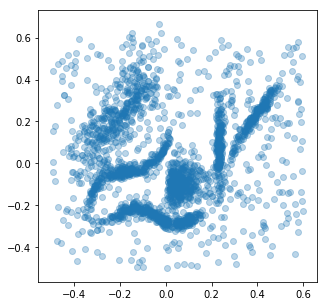

In [5]:
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[:,0], fuzzy[:,1],alpha=.3)

In [45]:
fuzzy_copy = deepcopy(fuzzy)
np.random.shuffle(fuzzy)

Set some parameters

In [46]:
k = 10 # number of clusters to go down to
stop_dist = 0.3
num_stop_crit = 1
stride = 2
data = fuzzy[::stride]
n = len(data) # number of data points
print(n)
link = 'average'
#link = 'complete'
#link = 'single'
metric='euclidean'

1155


Fit hierarchical clustering object and plot results

Hierarchical clustering terminated.
Finished after 0:00:05.596577
Stopping cluster number was reached.
Current number of clusters: 10
Current minimum cluster distance: 0.3


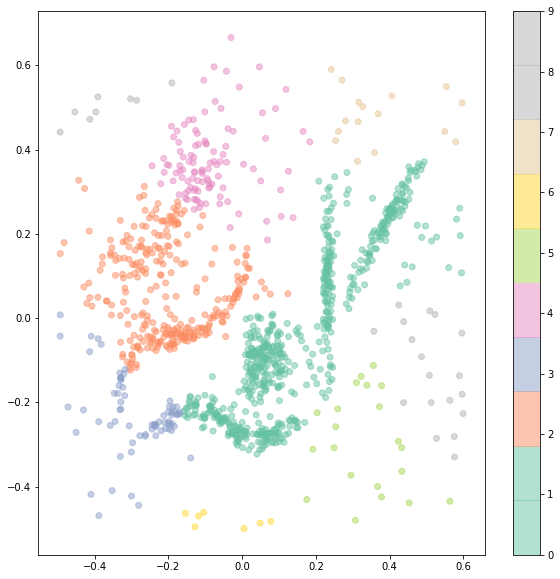

In [47]:
hiercl_obj = similarity.HierarchicalClustering(data, link=link, num_stop_crit=num_stop_crit, metric=metric, k=k, stop_dist=stop_dist)
hiercl_obj.fit()
labels = hiercl_obj.cluster_labels
plt.figure(figsize=(10, 10))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

Fit some other clustering methods

Detected 7 clusters
Finished after 0:00:00.093427
Rate of noise in dataset: 0.288312


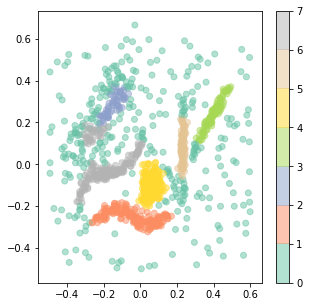

In [48]:
dbscan_obj = density.DBSCAN(data, eps=0.03, minPts=10)
dbscan_obj.fit()
labels = dbscan_obj.cluster_labels
for i in range(len(labels)):
    if labels[i] == 'noise':
        labels[i] = 0
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', dbscan_obj._n_clusters), alpha=.5)
plt.colorbar()

terminated by break condition
20 iterations until termination.
Finished after 0:00:00.019968
max within-cluster distance to center: 0.354455
mean within-cluster distance to center: 0.085496
sum of within cluster squared errors: 12.119611


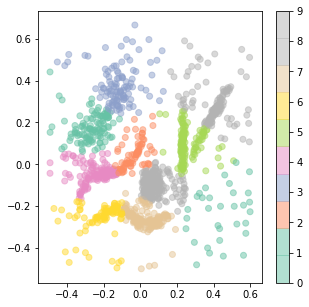

In [49]:
kmeans_obj = cl_dist.KMeans(data, 10)
kmeans_obj.fit()
labels = kmeans_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

Constructing gaussian similarity matrix
Computing generalized Laplacian eigenproblem


KMeans initialization on eigenvectors...
terminated by break condition
7 iterations until termination.
Finished after 0:00:00.029900
max within-cluster distance to center: 0.383232
mean within-cluster distance to center: 0.063050
sum of within cluster squared errors: 7.229535
KMeans terminated. 

Finished after 0:00:12.907627


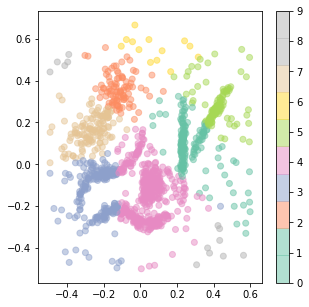

In [50]:
spectral_obj = similarity.SpectralClustering(data, n=10, bandwidth=0.1)
spectral_obj.fit()
labels = spectral_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

Set some parameters

In [60]:
stride = 2
data = fuzzy[::stride]
n = len(data)

#clusterings = [kmeans_obj, kmeans_obj]
#clusterings = [hiercl_obj, hiercl_obj]
#clusterings = [kmeans_obj, dbscan_obj]
clusterings = [spectral_obj, dbscan_obj, kmeans_obj, hiercl_obj]
recluster_what = 'clusters'
#recluster_what = 'points'
#how = 'hierarchical'
how = 'spectral'
k = 8 # how many clusters to produce

Computing generalized Laplacian eigenproblem


KMeans initialization on eigenvectors...
terminated by break condition
1 iterations until termination.
Finished after 0:00:00.014111
max within-cluster distance to center: 16.753801
mean within-cluster distance to center: 6.689900
sum of within cluster squared errors: 2509.678423
KMeans terminated. 

Finished after 0:00:00.016741
Consensus clustering terminated.
Finished after 0:00:00.043312


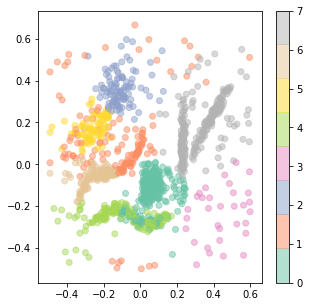

In [61]:
consensus_obj = consensus.Consensus(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how)
consensus_obj.fit()
labels = consensus_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()